# Unisolar Projet: Modeling
---

## Imports

In [114]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from matplotlib.dates import HourLocator,DateFormatter

from sklearn.metrics import mean_squared_error, mean_absolute_error
from unisolar_utils import (naive_predictions,
                            plot_naive_predictions,
                            print_naive_predictions_metrics,
                            train_valid_test_split_df,
                            plot_train_valid_test,
                            to_seq2seq_dataset,
                            plot_training_history,
                            plot_random_predictions,
                            prediction_df,
                            create_error_list)

import tensorflow as tf
from tensorflow.keras.regularizers import l2

## Loading data

In [115]:
df_preprocess = pd.read_csv('preprocessed_data.csv', index_col='Timestamp', parse_dates=['Timestamp'])
df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61343 entries, 2020-01-01 00:15:00 to 2021-09-30 23:45:00
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SolarGeneration   61343 non-null  float64
 1   AirTemperature    61343 non-null  float64
 2   RelativeHumidity  61343 non-null  float64
 3   WindSpeed         61343 non-null  float64
 4   WindDirection     61343 non-null  float64
dtypes: float64(5)
memory usage: 2.8 MB


Let's resample the data to 1 hour time steps instead of 15 minutes.

In [116]:
df_preprocess_resampled = df_preprocess.resample('1h').agg({"SolarGeneration": "mean",
                                                            "AirTemperature": "mean",
                                                            "RelativeHumidity": "mean",
                                                            "WindSpeed": "mean",
                                                            "WindDirection": lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan})

In [117]:
df_preprocess_resampled.head()

,SolarGeneration,AirTemperature,RelativeHumidity,WindSpeed,WindDirection
Timestamp,,,,,
2020-01-01 00:00:00,0.0,13.617778,51.600000,13.920000,148.533333
2020-01-01 01:00:00,0.0,12.995000,57.416667,13.360000,160.400000
2020-01-01 02:00:00,0.0,12.391667,64.900000,10.646667,156.933333
2020-01-01 03:00:00,0.0,12.116667,70.000000,10.960000,182.800000
2020-01-01 04:00:00,0.0,13.078333,66.000000,15.405000,173.266667


## Naive Model

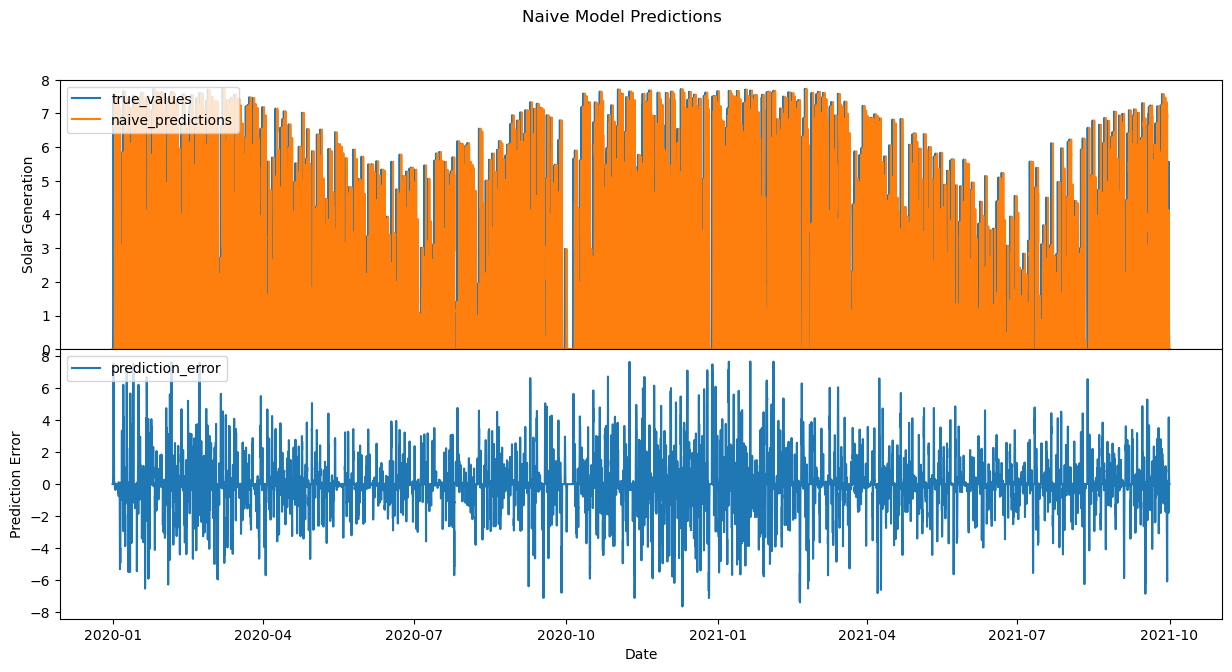

In [118]:
plot_naive_predictions(df_preprocess_resampled)

In [119]:
print_naive_predictions_metrics(df_preprocess_resampled)

Mean Squared Error: 1.6724112201266499
Mean Absolute Error: 0.5878096533483308


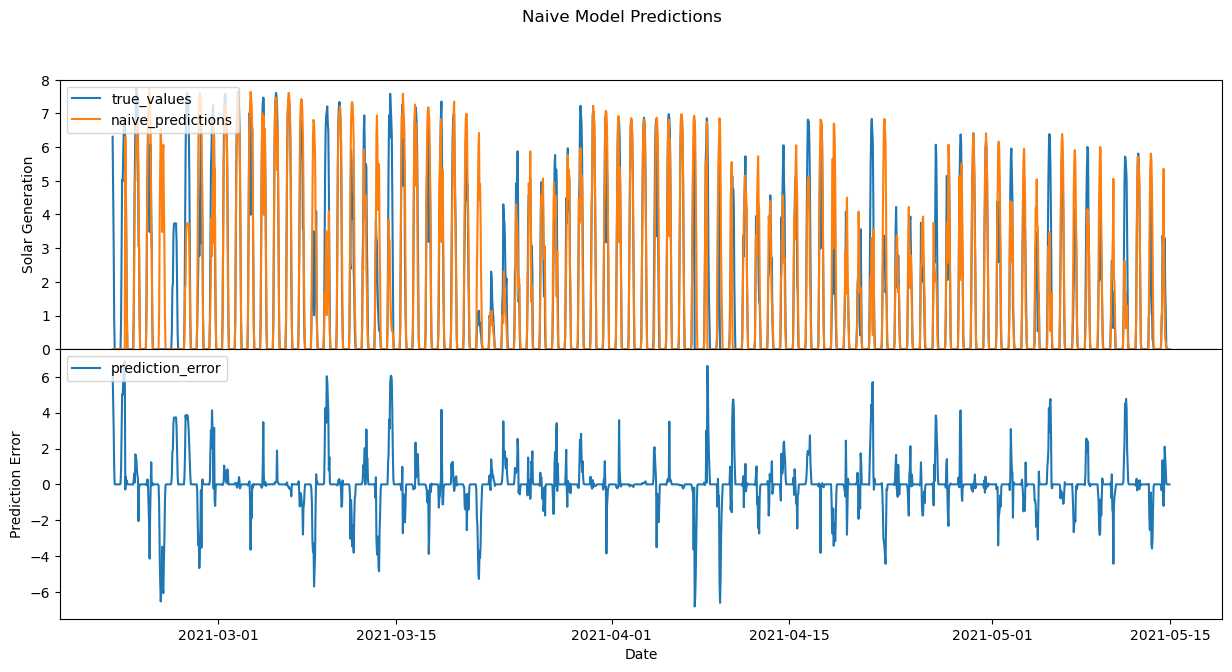

In [120]:
plot_naive_predictions(df_preprocess_resampled[10000:12000])

In [121]:
print_naive_predictions_metrics(df_preprocess_resampled[10000:12000])

Mean Squared Error: 1.7085420761108399
Mean Absolute Error: 0.569470703125


## Feature Engineering

Let's create seasonal feature to represent the daily and yearly periodicity of the solar generation. The solar generation over one day is periodic but does not follow a simple sinusoidal function. We add a couple harmonics to improve predictions.

In [122]:
harmonics=3
for h in range(harmonics):
    h += 1
    df_preprocess_resampled[f'day_sine{h}'] = np.sin(df_preprocess_resampled.index.hour/24*2*np.pi*h)
    df_preprocess_resampled[f'day_cosine{h}'] = np.cos(df_preprocess_resampled.index.hour/24*2*np.pi*h)

In [123]:
df_preprocess_resampled['year_sine'] = np.sin(df_preprocess_resampled.index.dayofyear/365*2*np.pi)
df_preprocess_resampled['year_cosine'] = np.cos(df_preprocess_resampled.index.dayofyear/365*2*np.pi)

Angles are not easily understood by ML algorithms. Let's encode the `WindSpeed` and `WindDirection` as a `WindVector`:

In [124]:
df_preprocess_resampled['WindX'] = np.cos(df_preprocess_resampled['WindDirection']/360*2*np.pi)*df_preprocess_resampled['WindSpeed']
df_preprocess_resampled['WindY'] = np.sin(df_preprocess_resampled['WindDirection']/360*2*np.pi)*df_preprocess_resampled['WindSpeed']
df_preprocess_resampled = df_preprocess_resampled.drop(columns=['WindDirection','WindSpeed'])

In [125]:
df_preprocess_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15336 entries, 2020-01-01 00:00:00 to 2021-09-30 23:00:00
Freq: H
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SolarGeneration   15336 non-null  float64
 1   AirTemperature    15336 non-null  float64
 2   RelativeHumidity  15336 non-null  float64
 3   day_sine1         15336 non-null  float64
 4   day_cosine1       15336 non-null  float64
 5   day_sine2         15336 non-null  float64
 6   day_cosine2       15336 non-null  float64
 7   day_sine3         15336 non-null  float64
 8   day_cosine3       15336 non-null  float64
 9   year_sine         15336 non-null  float64
 10  year_cosine       15336 non-null  float64
 11  WindX             15336 non-null  float64
 12  WindY             15336 non-null  float64
dtypes: float64(13)
memory usage: 1.6 MB


## Train Test Split

We will first create a simple train/validation/test split of the data. We will train the model on the first year of data, validate it on the next 6 months, and keep the last 6 months for testing the model's performance.

In [126]:
df_train, df_valid, df_test = train_valid_test_split_df(df_preprocess_resampled, "2021-01", "2021-06")

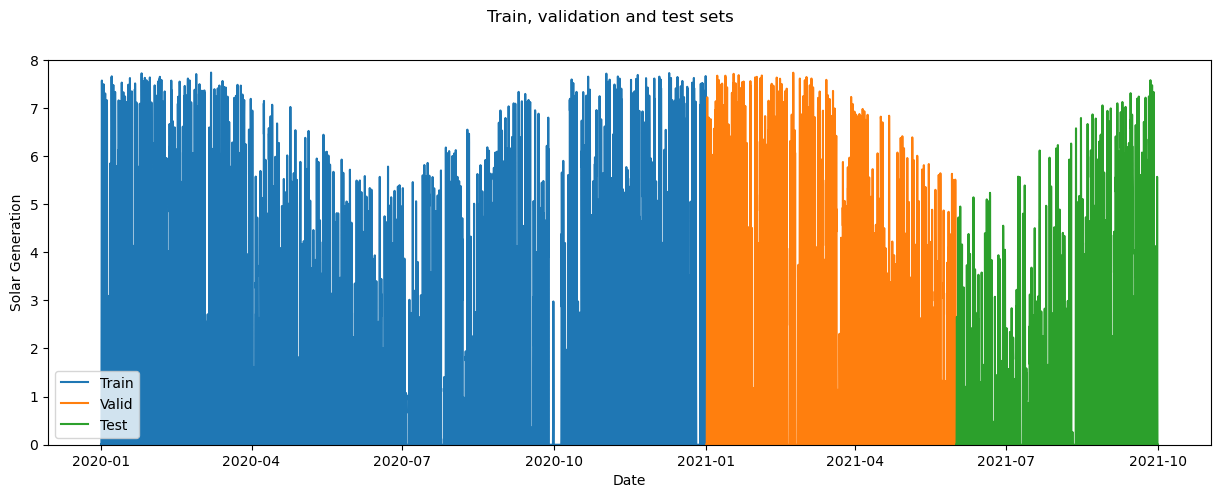

In [127]:
plot_train_valid_test(df_train, df_valid, df_test)

The lack of data around 2020-10 is probably the reason why our models will usually perform better on the validation set than on the training set.

## Preprocessing

We need to apply two preprocessing steps to the data: `StandardScaler` to the numerical features `AirTemperature`,	`RelativeHumidity` and `WindSpeed`, and one-hot for any categoricak we may have (in this case we don't). We leave the target columns `SolarGeneration` untouched.

In [128]:
categorical_features = list(df_preprocess_resampled.select_dtypes(include='category').columns)

column_transformer = ColumnTransformer([
    ('target', 'passthrough', ['SolarGeneration',]),
    ('ohe', OneHotEncoder(sparse_output=False, drop=None), categorical_features)
    ],
    remainder=StandardScaler()
)

In [129]:
df_train_transf = column_transformer.fit_transform(df_train)
df_valid_transf = column_transformer.transform(df_valid)
df_test_transf = column_transformer.transform(df_test)

## RNN

We will first prepare a recurrent neural network using Gated Recurrent Units (GRU) to predict `SolarGeneration`. We will use the last 7 days of data and forecast the next 24 hours.

In [130]:
prediction_window, training_window = 24, 7*24
n_inputs = df_train_transf.shape[-1]

We prepare the data for a sequence to sequence model outputting a vector of the next 24 hours of `SolarGeneration` at every time step. To do so, we use the function detailed in "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow" by A. Géron chapter 15. It can also be found on [GitHub](https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb).


In [131]:
ds_train = to_seq2seq_dataset(df_train_transf, training_window, prediction_window, 0, shuffle=True)
ds_valid = to_seq2seq_dataset(df_valid_transf, training_window, prediction_window, 0)
ds_test = to_seq2seq_dataset(df_test_transf, training_window, prediction_window, 0)

We set the optimizer and callbacks for our model. We will save our model parameters to avoid rerunning it every time.

In [132]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

rnn_checkpoint_path = 'model/rnn/rnn_{epoch:04d}'
rnn_checkpoint_dir = os.path.dirname(rnn_checkpoint_path)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
rnn_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=rnn_checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)

rnn_callbacks = [early_stopping, rnn_checkpoint]


This model was chosen by varying the parameters (number of layers, units and regularization), training the model using GPU of Kaggle notebooks and comparing the results. Here we will use a model that performed well while being simple enough to be trained on CPU in a few minutes.

In [133]:
rnn_model = tf.keras.Sequential([
    tf.keras.layers.GRU(128, input_shape=[training_window, n_inputs], return_sequences=True, kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(prediction_window, activation='relu')])

rnn_model.compile(optimizer=optimizer, loss='mae', metrics=['mae','mse',])

In [134]:
rnn_model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 168, 128)          54912     
                                                                 
 dropout_58 (Dropout)        (None, 168, 128)          0         
                                                                 
 dense_24 (Dense)            (None, 168, 64)           8256      
                                                                 
 dropout_59 (Dropout)        (None, 168, 64)           0         
                                                                 
 dense_25 (Dense)            (None, 168, 24)           1560      
                                                                 
Total params: 64,728
Trainable params: 64,728
Non-trainable params: 0
_________________________________________________________________


We can load the model's best parameters from the `model\rnn` directory.

In [135]:
latest = tf.train.latest_checkpoint(rnn_checkpoint_dir)
rnn_model.load_weights(latest)

Epoch 1/50


    269/Unknown - 48s 149ms/step - loss: 0.8011 - mae: 0.7491 - mse: 2.1117
Epoch 1: val_loss improved from inf to 0.57361, saving model to model/rnn/rnn_0001
269/269 [==============================] - 55s 174ms/step - loss: 0.8011 - mae: 0.7491 - mse: 2.1117 - val_loss: 0.5736 - val_mae: 0.5610 - val_mse: 1.2306
Epoch 2/50
269/269 [==============================] - ETA: 0s - loss: 0.5855 - mae: 0.5745 - mse: 1.2778
Epoch 2: val_loss improved from 0.57361 to 0.56107, saving model to model/rnn/rnn_0002
269/269 [==============================] - 47s 157ms/step - loss: 0.5855 - mae: 0.5745 - mse: 1.2778 - val_loss: 0.5611 - val_mae: 0.5508 - val_mse: 1.2562
Epoch 3/50
269/269 [==============================] - ETA: 0s - loss: 0.5532 - mae: 0.5432 - mse: 1.1627
Epoch 3: val_loss improved from 0.56107 to 0.54748, saving model to model/rnn/rnn_0003
269/269 [==============================] - 46s 156ms/step - loss: 0.5532 - mae: 0.5432 - mse: 1.1627 - val_loss: 0.5475 - val_mae: 0.5375 - val_m

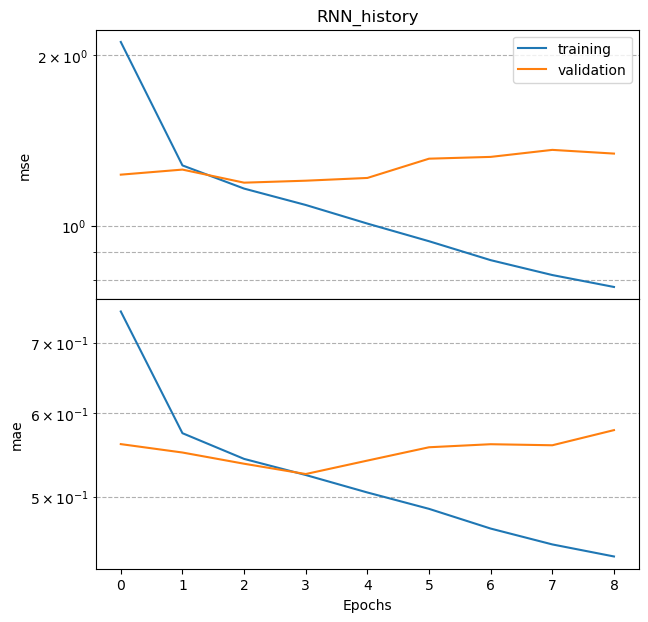

In [136]:
# rnn_history = rnn_model.fit(ds_train, validation_data=ds_valid, epochs=50, callbacks=rnn_callbacks)
# plot_training_history(rnn_history,'RNN_history')

Now we can predict `SolarGeneration`from the test dataset.

In [137]:
rnn_predictions = rnn_model.predict(ds_valid)
prediction_df_rnn = prediction_df(rnn_predictions, df_valid, prediction_window, training_window)

108/108 [==============================] - 5s 37ms/step


We can build a dataframe containing for each moment, the predictions and labels for each hour and forecast horizon (1 hour up to 24 hours).

3433


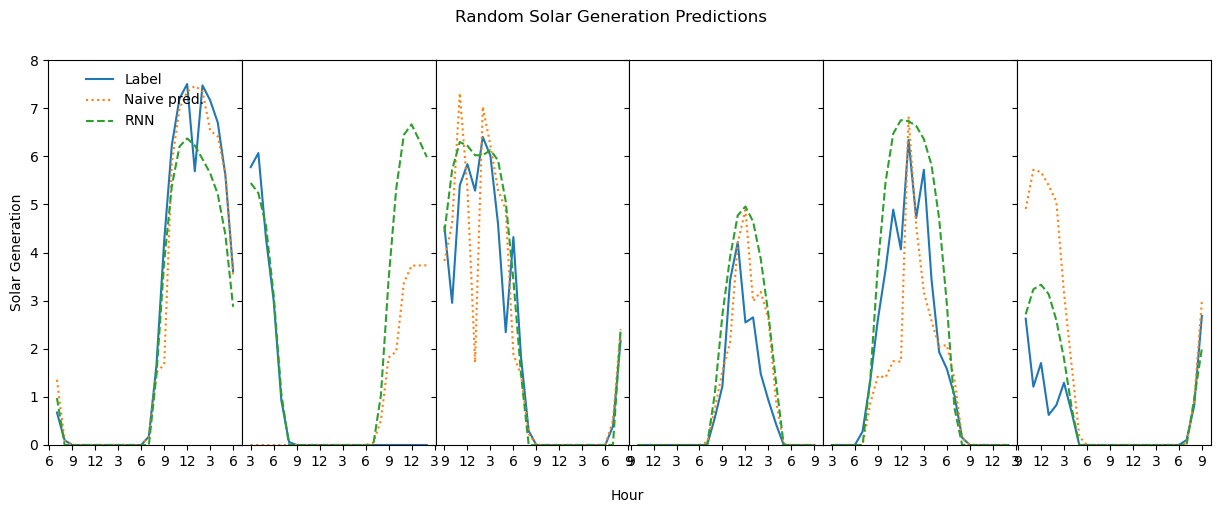

In [138]:
plot_random_predictions(df_valid, {'RNN':rnn_predictions}, training_window, prediction_window)

In [139]:
rnn_mae, rnn_mse = create_error_list(prediction_df_rnn, prediction_window)
print('RNN model')
print(f'Mean Squared Error: {np.mean(rnn_mse)}')
print(f'Mean Absolute Error: {np.mean(rnn_mae)}')


RNN model
Mean Squared Error: 1.1301319734207311
Mean Absolute Error: 0.5027835585379382


In [140]:
print('Naive Model')
print_naive_predictions_metrics(df_valid)

Naive Model
Mean Squared Error: 1.9562271615001012
Mean Absolute Error: 0.6369914545391833


## CNN Model

In [141]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

cnn_checkpoint_path = 'model/cnn/cnn_{epoch:04d}'
cnn_checkpoint_dir = os.path.dirname(cnn_checkpoint_path)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)
cnn_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=cnn_checkpoint_path, save_weights_only=True, save_best_only=True, verbose=1)

cnn_callbacks = [early_stopping, cnn_checkpoint]

In [142]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 4, input_shape=[training_window, n_inputs], padding='causal', activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Conv1D(64, 4, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Conv1D(128, 4, padding='causal', activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),

    tf.keras.layers.Dense(prediction_window, 'relu')
])

cnn_model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'])

In [143]:
cnn_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_48 (Conv1D)          (None, 168, 32)           1696      
                                                                 
 dropout_60 (Dropout)        (None, 168, 32)           0         
                                                                 
 conv1d_49 (Conv1D)          (None, 168, 64)           8256      
                                                                 
 dropout_61 (Dropout)        (None, 168, 64)           0         
                                                                 
 conv1d_50 (Conv1D)          (None, 168, 128)          32896     
                                                                 
 dropout_62 (Dropout)        (None, 168, 128)          0         
                                                                 
 dense_26 (Dense)            (None, 168, 24)         

In [144]:
latest = tf.train.latest_checkpoint(cnn_checkpoint_dir)
cnn_model.load_weights(latest)

ValueError: Received incompatible tensor with shape (256,) when attempting to restore variable with shape (24,) and name layer_with_weights-3/bias/.ATTRIBUTES/VARIABLE_VALUE.

In [ ]:
# cnn_history = cnn_model.fit(ds_train, validation_data=ds_valid, epochs=50, callbacks=cnn_callbacks)
# plot_training_history(cnn_history,'CNN_history')

Epoch 1/50
    268/Unknown - 11s 24ms/step - loss: 0.7025 - mae: 0.7025 - mse: 1.8892
Epoch 1: val_loss did not improve from 0.49954
269/269 [==============================] - 13s 30ms/step - loss: 0.7022 - mae: 0.7022 - mse: 1.8880 - val_loss: 0.5507 - val_mae: 0.5507 - val_mse: 1.1695
Epoch 2/50
268/269 [============================>.] - ETA: 0s - loss: 0.5565 - mae: 0.5565 - mse: 1.2005
Epoch 2: val_loss did not improve from 0.49954
269/269 [==============================] - 11s 31ms/step - loss: 0.5564 - mae: 0.5564 - mse: 1.2000 - val_loss: 0.5153 - val_mae: 0.5153 - val_mse: 1.1141
Epoch 3/50
268/269 [============================>.] - ETA: 0s - loss: 0.5294 - mae: 0.5294 - mse: 1.1012
Epoch 3: val_loss did not improve from 0.49954
269/269 [==============================] - 11s 31ms/step - loss: 0.5294 - mae: 0.5294 - mse: 1.1014 - val_loss: 0.5174 - val_mae: 0.5174 - val_mse: 1.0662
Epoch 4/50
268/269 [============================>.] - ETA: 0s - loss: 0.5116 - mae: 0.5116 - mse: 

In [ ]:
cnn_predictions = cnn_model.predict(ds_valid)

108/108 [==============================] - 1s 12ms/step


In [ ]:
prediction_df_cnn = prediction_df(cnn_predictions, df_valid, prediction_window, training_window)

3433


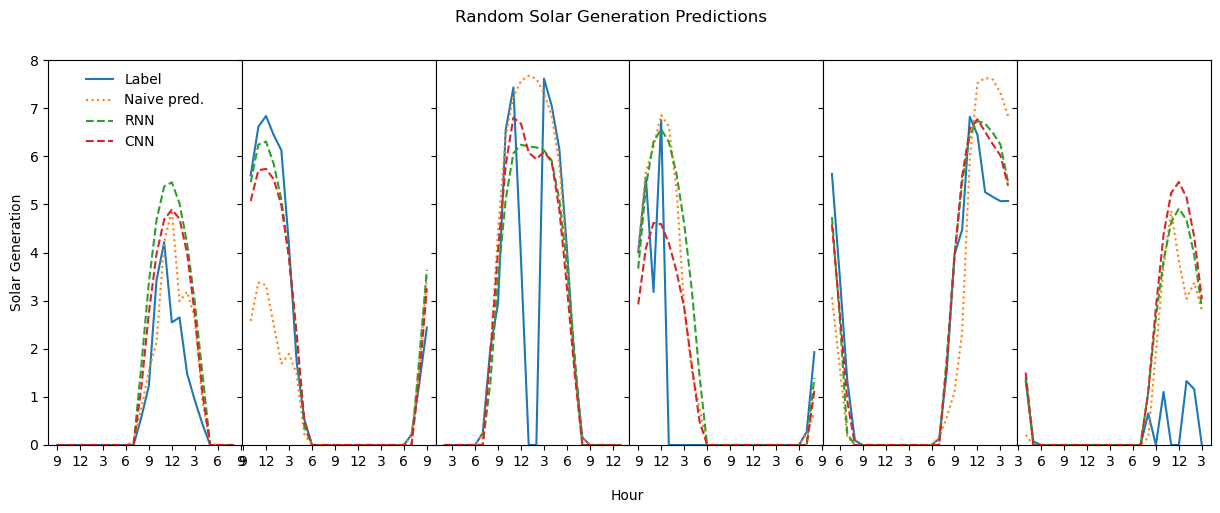

In [ ]:
plot_random_predictions(df_valid, {'RNN':rnn_predictions, 'CNN':cnn_predictions}, training_window, prediction_window)

In [ ]:
rnn_mae, rnn_mse = create_error_list(prediction_df_cnn, prediction_window)
print('CNN model')
print(f'Mean Squared Error: {np.mean(rnn_mse)}')
print(f'Mean Absolute Error: {np.mean(rnn_mae)}')

CNN model
Mean Squared Error: 1.0293735804421056
Mean Absolute Error: 0.49328077283218247
